# Receptive fields

We will obtain the receptive fields of any given model by building deltas as inputs to calculate the differential response of the model.

## Importing libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import get_file

from perceptnet.networks import PerceptNet
from perceptualtests.receptive_fields import *

## Define a `tf.data.Dataset` from the deltas generator

In [2]:
img_height, img_width, channels, fov = 384, 512, 3, 32

In [3]:
deltas_dataset = tf.data.Dataset.from_generator(obtain_receptive_field_gen, 
                                                args=(img_height,img_width,channels,fov),
                                                output_signature=(
                                                    tf.TensorSpec(shape=(img_height,img_width,channels), dtype=tf.float32)
                                                    )
                                                )

2022-05-04 08:19:51.650333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:83:00.0, compute capability: 3.5


## Passing the deltas through the network

In [4]:
weights_path = get_file(fname='perceptnet_rgb.h5',
                        origin='https://github.com/Jorgvt/perceptnet/releases/download/Weights/final_model_rgb.h5')

In [5]:
model = PerceptNet(kernel_initializer='ones', gdn_kernel_size=1, learnable_undersampling=False)
model.build(input_shape=(None, 384, 512, 3))
model.load_weights(weights_path)

### Keeping only one channel

In [6]:
%%time
channel_to_keep = 0
batch_size = 10

responses = np.empty(shape=(fov*2)*(fov*2)*channels)
for i, delta in tqdm(enumerate(deltas_dataset.batch(batch_size)), total=fov*2*fov*2*channels//batch_size):
    response = model.predict(delta)
    ## Now we keep only the center response of a specific channel
    response_height, response_width = response.shape[1:3] # [BatchDim, H, W, C]
    responses[i*batch_size:i*batch_size+batch_size] = response[:,response_height//2,response_width//2,channel_to_keep]

2022-05-04 08:19:52.896178: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  0%|          | 0/1228 [00:00<?, ?it/s]

2022-05-04 08:19:54.168513: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-05-04 08:19:54.755694: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


CPU times: user 3min 36s, sys: 1min 12s, total: 4min 49s
Wall time: 4min 32s


In [7]:
responses2 = responses.reshape((fov*2, fov*2, channels))
# rf = (responses2 - responses2.min()) / (responses2.max() - responses2.min())
rf = normalization_fixed_0(responses2)
rf.shape

(64, 64, 3)

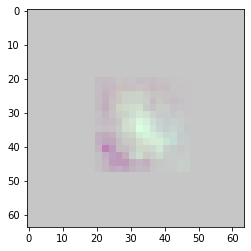

In [8]:
plt.imshow(rf)
plt.show()

### Keeping all the channels

In [10]:
%%time
batch_size = 16
output_channels = 128

responses = np.empty(shape=((fov*2)*(fov*2)*channels, output_channels))
for i, delta in tqdm(enumerate(deltas_dataset.batch(batch_size)), total=fov*2*fov*2*channels//batch_size):
    response = model.predict(delta)
    ## Now we keep only the center response of a specific channel
    response_height, response_width = response.shape[1:3] # [BatchDim, H, W, C]
    responses[i*batch_size:i*batch_size+batch_size] = response[:,response_height//2,response_width//2,:]

  0%|          | 0/768 [00:00<?, ?it/s]

CPU times: user 3min 1s, sys: 1min 26s, total: 4min 28s
Wall time: 4min 18s


In [11]:
responses.shape, response.shape

((12288, 128), (16, 96, 128, 128))

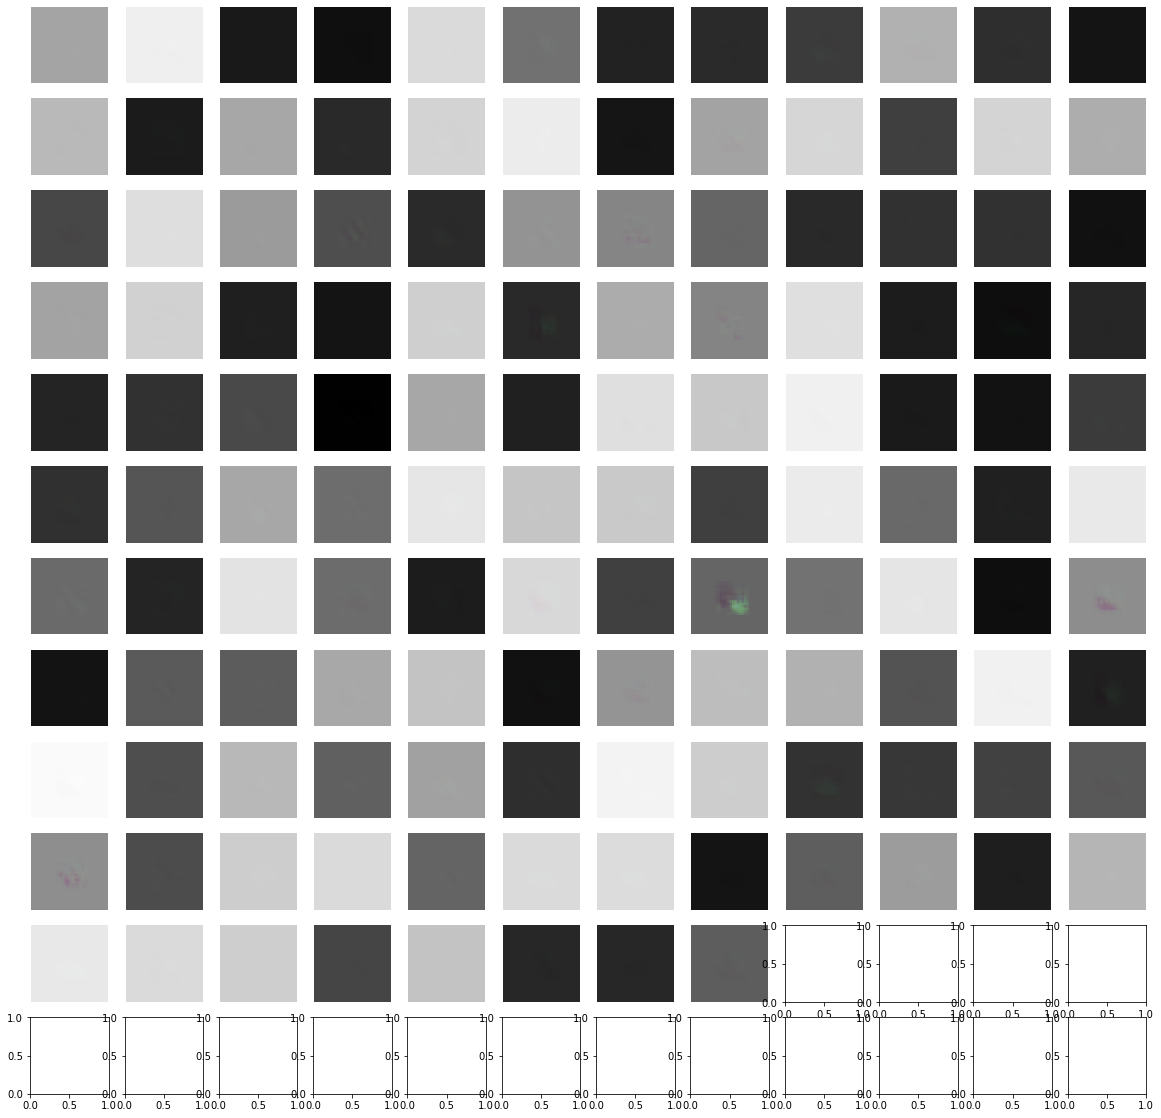

In [12]:
responses = normalization_fixed_0(responses, 0.5)

nrows, ncols = [int(np.ceil(np.sqrt(output_channels)))]*2
fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))
ax = ax.ravel()
for ch in range(output_channels):
    ch_response = responses[:,ch]
    ch_response = ch_response.reshape((fov*2, fov*2, channels))
    # ch_response = (ch_response - ch_response.min()) / (ch_response.max() - ch_response.min())
    ax[ch].imshow(ch_response)
    ax[ch].axis('off')
    # break
plt.show()